## load data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/PLP_project/data/'

In [ ]:
import os
os.chdir('/content/drive/MyDrive/PLP_project/finetuning_mistral_7b')

In [ ]:
# load the data locally

import json

# load the whole dataset
with open('/content/drive/MyDrive/PLP_project/data/alldata.json', 'r', encoding='utf-8') as file:
    alldata = json.load(file)
print("# Total alldata samples:", len(alldata))
print()

# split evaluation_dataset
# evaluation_dataset = alldata[42000:42200]
evaluation_dataset = alldata[42000:42010]
print("# evaluation_dataset samples:", len(evaluation_dataset))
print("evaluation_dataset 1st sample:", evaluation_dataset[0])



# Total alldata samples: 43713

# evaluation_dataset samples: 10
evaluation_dataset 1st sample: {'id': 112194, 'context': 'Neural Mesh: Introducing a Notion of Space and Conservation of Energy to   Neural Networks.Neural networks are based on a simplified model of the brain. In this project, we wanted to relax the simplifying assumptions of a traditional neural network by making a model that more closely emulates the low level interactions of neurons. Like in an RNN, our model has a state that persists between time steps, so that the energies of neurons persist. However, unlike an RNN, our state consists of a 2 dimensional matrix, rather than a 1 dimensional vector, thereby introducing a concept of distance to other neurons within the state. In our model, neurons can only fire to adjacent neurons, as in the brain. Like in the brain, we only allow neurons to fire in a time step if they contain enough energy, or excitement. We also enforce a notion of conservation of energy, so that a ne

In [ ]:
# df_train: pd.DataFrame = pd.read_json(data_path + 'train.json')
# df_test: pd.DataFrame = pd.read_json(data_path + 'test.json')
# df_validation: pd.DataFrame = pd.read_json(data_path + 'val.json')

In [ ]:
df_evaluation = pd.DataFrame(evaluation_dataset)


In [ ]:
# 合并 question 和 context 列为新的列 input
df_evaluation['input'] = 'question: "' + df_evaluation['question'] + '" \n context: "' + df_evaluation['context'] + '"'

In [ ]:
prompt_template: str = """
You are a helpful, respectful and honest assistant. \
Your task is to generate an answer to the given question. \
And your answer should be based on the provided context only.

### Input: {input}

### Answer:
"""

In [ ]:
df_evaluation["prompt"] = df_evaluation["input"].apply(lambda x: prompt_template.format(**{"input": x}))

In [ ]:
df_evaluation['prompt']

0    \nYou are a helpful, respectful and honest ass...
1    \nYou are a helpful, respectful and honest ass...
2    \nYou are a helpful, respectful and honest ass...
3    \nYou are a helpful, respectful and honest ass...
4    \nYou are a helpful, respectful and honest ass...
5    \nYou are a helpful, respectful and honest ass...
6    \nYou are a helpful, respectful and honest ass...
7    \nYou are a helpful, respectful and honest ass...
8    \nYou are a helpful, respectful and honest ass...
9    \nYou are a helpful, respectful and honest ass...
Name: prompt, dtype: object

## load base model

In [ ]:
import transformers
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, LlamaForCausalLM, MistralForCausalLM, AutoTokenizer, LlamaTokenizerFast, GenerationConfig, TextGenerationPipeline, BatchEncoding
from transformers.generation.utils import GreedySearchDecoderOnlyOutput
import torch
from torch import Tensor

In [ ]:
# !pip install accelerate

In [ ]:
# !pip install git+https://github.com/huggingface/transformers

In [ ]:
!pip install -q peft  accelerate bitsandbytes safetensors

In [ ]:
bnb_config_base_model: BitsAndBytesConfig = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [ ]:
mistral_7b_sharded_base_model_name: str = "alexsherstinsky/Mistral-7B-v0.1-sharded"

In [ ]:
base_model_tokenizer: LlamaTokenizerFast = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=mistral_7b_sharded_base_model_name, trust_remote_code=True, padding_side="left")
print(base_model_tokenizer.eos_token)
base_model_tokenizer.pad_token = base_model_tokenizer.eos_token

</s>


In [ ]:
base_model: MistralForCausalLM = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=mistral_7b_sharded_base_model_name, device_map="auto", torch_dtype=torch.float16, offload_folder="offload", trust_remote_code=True, low_cpu_mem_usage=True, quantization_config=bnb_config_base_model)

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

## Inference

In [ ]:
base_model_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task="text-generation",
    tokenizer=base_model_tokenizer,
    model=base_model,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
# 初始化一个空的列表来存储推理结果
results = []

# 循环遍历每个文本进行推理
for i in range(len(df_evaluation)):
    sample = df_evaluation.iloc[i]
    # 生成推理结果
    generated_text_dict = base_model_sequences_generator(
        text_inputs=sample["prompt"],
        do_sample=True,
        top_k=50,
        num_return_sequences=1,
        eos_token_id=base_model_tokenizer.eos_token_id,
        max_new_tokens=128,
        return_text=True,
    )[0]
    # 提取生成的答案部分
    generated_text = generated_text_dict['generated_text']
    answer_text = generated_text.replace(sample["prompt"], "").strip()
    result = {
        'id': int(sample['id']),  # 将 int64 转换为整数
        'question': sample['question'],
        'ground_truth': sample['answer'],
        'answer': answer_text
    }
    results.append(result)

# 将推理结果保存到 JSON 文件中
json_file_path = '/content/drive/My Drive/results.json_1'
with open(json_file_path, 'w') as f:
    json.dump(results, f)

print("Results saved to:", json_file_path)


Results saved to: /content/drive/My Drive/results.json_1


## Evaluate the model performance


- semantic similarity (METEOR and BERTScore)
- word and phrase level overlap (BLEU and ROUGE scores)
- human evaluation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and check the results JSON file

import json

with open("/content/drive/MyDrive/results.json", "r") as f:
    test_dataset_results = json.load(f)
print("# results samples:", len(test_dataset_results))

# Check the 1st sample
test_dataset_results[0]


# results samples: 200


{'id': 112194,
 'question': 'What is the unique feature of the Neural Mesh architecture?',
 'ground_truth': 'The unique feature of the Neural Mesh architecture is the introduction of a 2 dimensional matrix state for neurons, which introduces a notion of spatial distance to other neurons within the network. This allows neurons to only fire to adjacent neurons, mimicking the interactions in the brain. Additionally, the model enforces a conservation of energy principle, ensuring that neurons cannot excite their neighbors more than their existing excitement level. These innovations enable signals in the form of activations to flow around the network over time, closely mirroring how signals travel through the brain.',
 'answer': '> The Neural Mesh is a concept in machine learning that was recently proposed by researchers at Google. It is based on the idea that neural networks are similar to the biological brain, and can be thought of as a physical structure rather than a mathematical abstra

In [ ]:
def load_results(file_path):
    results = []
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
            for item in data:
                result = {
                    'id': item.get('id'),
                    'question': item.get('question'),
                    'ground_truth': item.get('ground_truth'),
                    'answer': item.get('answer')
                }
                results.append(result)
        return results
    except FileNotFoundError:
        print("File not found:", file_path)
    except json.JSONDecodeError:
        print("Invalid JSON format in file:", file_path)
    return []

# Load results from the file
results = load_results("/content/drive/MyDrive/results.json")

In [ ]:
results

[{'id': 112194,
  'question': 'What is the unique feature of the Neural Mesh architecture?',
  'ground_truth': 'The unique feature of the Neural Mesh architecture is the introduction of a 2 dimensional matrix state for neurons, which introduces a notion of spatial distance to other neurons within the network. This allows neurons to only fire to adjacent neurons, mimicking the interactions in the brain. Additionally, the model enforces a conservation of energy principle, ensuring that neurons cannot excite their neighbors more than their existing excitement level. These innovations enable signals in the form of activations to flow around the network over time, closely mirroring how signals travel through the brain.',
  'answer': '> The Neural Mesh is a concept in machine learning that was recently proposed by researchers at Google. It is based on the idea that neural networks are similar to the biological brain, and can be thought of as a physical structure rather than a mathematical ab

In [ ]:
!pip install rouge
!pip install bert-score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
# Optimized code
# semantic similarity (METEOR and BERTScore)
# word and phrase level overlap (BLEU and ROUGE scores)

import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from bert_score import score

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')


def calculate_scores(results):
    total_bert_score = 0
    total_meteor_score = 0
    total_bleu_score = 0
    total_rouge_score = {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}
    num_results = len(results)

    for result in results:
        answer = result.get('answer')
        ground_truth = result.get('ground_truth')

        if not answer or not ground_truth:
            continue  # Skip empty answers or ground truths

        # Tokenize hypothesis and reference
        hypothesis_tokens = word_tokenize(answer)
        reference_tokens = word_tokenize(ground_truth)

        # BERTScore
        _, _, F1 = score([answer], [ground_truth], lang='en', verbose=False)
        total_bert_score += F1.item()

        # METEOR
        meteor = meteor_score([reference_tokens], hypothesis_tokens)
        total_meteor_score += meteor

        # BLEU
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=None)
        total_bleu_score += bleu_score

        # ROUGE
        rouge = Rouge()
        rouge_scores = rouge.get_scores(answer, ground_truth)[0]
        for metric, scores in rouge_scores.items():
            total_rouge_score[metric] += scores['f']

    average_bert_score = total_bert_score / num_results
    average_meteor_score = total_meteor_score / num_results
    average_bleu_score = total_bleu_score / num_results
    average_rouge_score = {metric: score / num_results for metric, score in total_rouge_score.items()}

    # Print average scores
    print("Average BERTScore:", average_bert_score)
    print("Average METEOR score:", average_meteor_score)
    print("Average BLEU score:", average_bleu_score)
    print("Average Rouge score:", average_rouge_score)

    # return average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score
    return 0

# Calculate scores
calculate_scores(results)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at ro

Average BERTScore: 0.8584343963861465
Average METEOR score: 0.30900218904106497
Average BLEU score: 0.06575236175204396
Average Rouge score: {'rouge-1': 0.29749334564705754, 'rouge-2': 0.10880294966630341, 'rouge-l': 0.2695593204016707}


0

## Visualization

### llama

- test_dataset_inference_results_0_best.json

Average BERTScore(F1): 0.9171436856389046

Average METEOR score: 0.5474461102655611

Average BLEU score: 0.22939051090323534

Average Rouge score: {'rouge-1': 0.5326981310578925, 'rouge-2': 0.3065083438932236, 'rouge-l': 0.5008402663761499}


- test_dataset_inference_results_base.json

Average BERTScore(F1): 0.8943092213273048

Average METEOR score: 0.4443633704095649

Average BLEU score: 0.13634204780069573

Average Rouge score: {'rouge-1': 0.4246577955218664, 'rouge-2': 0.19931899333659336, 'rouge-l': 0.39204521176654894}


### mistral_base_model

Average BERTScore: 0.8584343963861465

Average METEOR score: 0.30900218904106497

Average BLEU score: 0.06575236175204396

Average Rouge score: {'rouge-1': 0.29749334564705754, 'rouge-2': 0.10880294966630341, 'rouge-l': 0.2695593204016707}

### show all results

In [ ]:
from tabulate import tabulate

# Define the x-axis labels
labels = ["BERTScore(F1)", "METEOR", "BLEU", "rouge-1", "rouge-2", "rouge-l"]

# Extract scores for finetuned model
llama_finetuned_scores = [0.9171436856389046, 0.5474461102655611, 0.22939051090323534, 0.5326981310578925, 0.3065083438932236, 0.5008402663761499]

# Extract scores for llama base model
llama_base_scores = [0.8943092213273048, 0.4443633704095649, 0.13634204780069573, 0.4246577955218664, 0.19931899333659336, 0.39204521176654894]

# Extract scores for mistral base model
mistral_base_scores = [0.8584343963861465, 0.30900218904106497, 0.06575236175204396, 0.29749334564705754, 0.10880294966630341, 0.2695593204016707]

# Calculate llama improvement as percentage
improvement = [((llama_finetuned_scores - llama_base_scores) / llama_base_scores) * 100 for llama_finetuned_scores, llama_base_scores in zip(llama_finetuned_scores, llama_base_scores)]

# Calculate llama surpassing mistral as percentage
surpassing = [((llama_base_scores - mistral_base_scores) / mistral_base_scores) * 100 for llama_base_scores, mistral_base_scores in zip(llama_base_scores, mistral_base_scores)]

# Create table headers
headers = ["Metric", "Finetuned Score", "Base Score", "Surpassing (%)", "Improvement (%)"]

# Combine data into a list of lists
data = zip(labels, llama_finetuned_scores, llama_base_scores, mistral_base_scores, surpassing, improvement)

# Print the table
print(tabulate(data, headers=headers, floatfmt=".7f"))


                  Metric    Finetuned Score    Base Score    Surpassing (%)    Improvement (%)
-------------  ---------  -----------------  ------------  ----------------  -----------------
BERTScore(F1)  0.9171437          0.8943092     0.8584344         4.1790992          2.5533075
METEOR         0.5474461          0.4443634     0.3090022        43.8058972         23.1978481
BLEU           0.2293905          0.1363420     0.0657524       107.3568830         68.2463441
rouge-1        0.5326981          0.4246578     0.2974933        42.7453090         25.4417408
rouge-2        0.3065083          0.1993190     0.1088029        83.1926377         53.7777904
rouge-l        0.5008403          0.3920452     0.2695593        45.4393086         27.7506398


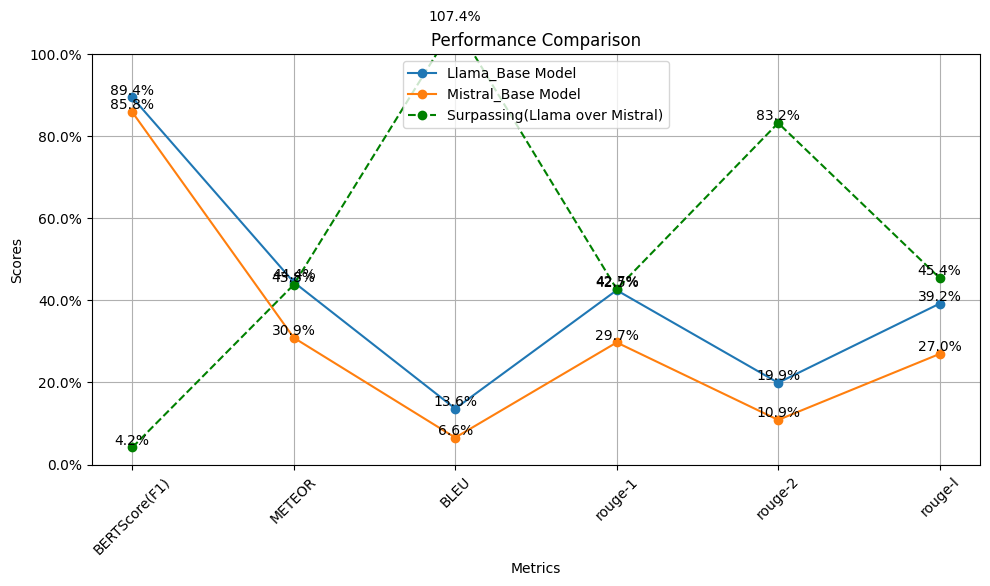

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to format y-axis labels as percentages
def percent(x, pos):
    return '%1.1f%%' % (x * 100)

# Define the x-axis labels
labels = ["BERTScore(F1)", "METEOR", "BLEU", "rouge-1", "rouge-2", "rouge-l"]

# Extract scores for llama base model
llama_base_scores = [0.8943092213273048, 0.4443633704095649, 0.13634204780069573, 0.4246577955218664, 0.19931899333659336, 0.39204521176654894]

# Extract scores for mistral base model
mistral_base_scores = [0.8584343963861465, 0.30900218904106497, 0.06575236175204396, 0.29749334564705754, 0.10880294966630341, 0.2695593204016707]

# Calculate llama surpassing mistral as percentage
surpassing = [((llama_base_scores - mistral_base_scores) / mistral_base_scores)  for llama_base_scores, mistral_base_scores in zip(llama_base_scores, mistral_base_scores)]


# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(labels, llama_base_scores, marker='o', label='Llama_Base Model')
plt.plot(labels, mistral_base_scores, marker='o', label='Mistral_Base Model')
plt.plot(labels, surpassing, marker='o', color='green', linestyle='--', label='Surpassing(Llama over Mistral)')
plt.title('Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Set y-axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(percent))

# Set y-axis limit to represent 100%
plt.ylim(0, 1)

# Add labels for each point on Llama Base Model line
for i in range(len(labels)):
    plt.text(labels[i], llama_base_scores[i], f'{llama_base_scores[i]*100:.1f}%', ha='center', va='bottom')

# Add labels for each point on MistralBase Model line
for i in range(len(labels)):
    plt.text(labels[i], mistral_base_scores[i], f'{mistral_base_scores[i]*100:.1f}%', ha='center', va='bottom')

# Add labels for each point on Surpassing line
for i in range(len(labels)):
    plt.text(labels[i], surpassing[i], f'{surpassing[i]*100:.1f}%', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


Is the performance good? Let's see what Claude 3 Sonnet says below:

BERTScore(F1): The finetuned model score of 0.9171 is very good, indicating high semantic similarity with the references. The base model score of 0.8943 is also good, but the finetuning has improved the BERTScore.

METEOR: The finetuned model score of 0.5474 is good according to the general guidelines for METEOR. The base model score of 0.4443 is mediocre, and the finetuning has significantly improved the METEOR score.

BLEU: The finetuned model score of 0.2294 is mediocre according to typical BLEU benchmarks. The base model score of 0.1363 is poor, but the finetuning has improved the BLEU score.

ROUGE-1: The finetuned model score of 0.5327 is good for ROUGE-1. The base model score of 0.4247 is mediocre, and the finetuning has improved the ROUGE-1 score.

ROUGE-2: The finetuned model score of 0.3065 is good for ROUGE-2. The base model score of 0.1993 is mediocre, and the finetuning has significantly improved the ROUGE-2 score.

ROUGE-L: The finetuned model score of 0.5008 is good for ROUGE-L. The base model score of 0.3920 is mediocre, and the finetuning has improved the ROUGE-L score.



Overall, the finetuned model has improved across all evaluation metrics compared to the base model. The improvements are particularly notable for METEOR, ROUGE-2, and ROUGE-L scores. The BERTScore was already good for the base model but has improved further with finetuning. While the BLEU score is still in the mediocre range, it has also seen an improvement from finetuning.

These results suggest that the finetuning process has been effective in enhancing the quality and similarity of the generated text to the reference texts based on these automatic evaluation metrics.

## Inference Time analyse

Llama2_13b :

Total running time: 68.99 seconds

Total number of tokens: 1270

per second: 18.408 tokens

Llama2_7b:

Total running time: 47.94 seconds

Total number of tokens: 1279

per second: 26.677 tokens

Mistral_7b:

Total running time: 351.67 seconds

Total number of tokens: 1261

per second: 3.566 tokens

In [ ]:
import time
import json

start_time = time.time()

# 初始化一个空的列表来存储推理结果
results = []

# 循环遍历每个文本进行推理
for i in range(len(df_evaluation)):
    sample = df_evaluation.iloc[i]
    # 生成推理结果
    generated_text_dict = base_model_sequences_generator(
        text_inputs=sample["prompt"],
        do_sample=True,
        top_k=50,
        num_return_sequences=1,
        eos_token_id=base_model_tokenizer.eos_token_id,
        max_new_tokens=128,
        return_text=True,
    )[0]
    # 提取生成的答案部分
    generated_text = generated_text_dict['generated_text']
    answer_text = generated_text.replace(sample["prompt"], "").strip()
    result = {
        'id': int(sample['id']),  # 将 int64 转换为整数
        'question': sample['question'],
        'ground_truth': sample['answer'],
        'answer': answer_text
    }
    results.append(result)

# 将推理结果保存到 JSON 文件中
json_file_path = '/content/drive/My Drive/results.json_1'
with open(json_file_path, 'w') as f:
    json.dump(results, f)

print("Results saved to:", json_file_path)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Read generated results from file
with open("./test_dataset_inference_results_base.json", "r") as f:
    generated_results = json.load(f)

# Calculate total number of tokens in generated results
total_tokens = sum(len(base_model_tokenizer.tokenize(result['answer'])) for result in generated_results)

# Calculate time per token
time_per_token = total_tokens / total_time

print("Total running time: {:.2f} seconds".format(total_time))
print("Total number of tokens: {}".format(total_tokens))
print("Time per token: {:.6f} seconds".format(time_per_token))

Results saved to: /content/drive/My Drive/results.json_1
Total running time: 351.67 seconds
Total number of tokens: 2503
Time per token: 0.140499 seconds
